# Notebook 2
## Model usage with real photos
In this notebbok the trained model is used to do face detection inside real photos. 

Model is imported from file through joblib module, and then is used with sliding window technique.
Face detection results are shown with bounding boxes overlaid on original photo, in a similar way as in a digital camera screen.

In this notebook all the script is written in python (there isn't a bash section like in Notebook 1).

In [15]:
#Import some modules
import joblib
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import pyramid_gaussian
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from ImageResizer import ImageResizer
from HOGFeatureExtractor import HOGFeatureExtractor
from skimage.color import rgb2gray
import matplotlib.patches as patches


### Utility functions

To do face detection the [sliding window](https://pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/) approach is used.

The image isn't passed to the model as whole, but it's divided in several portions (windows) and then each window is passed to the model. Visually it seems that there is a window sliding on the image, and from this the name _sliding windows_.

In this implementation windows may overlap, and it depends on _window_size_ and _step_size_ parameters: each window has size equal to _window_size_, while _step_size_ controls how much window slides in each turn: if _step_size_ is less than window width and/or height windows will horizontally and/or vertically overlap.

Changing _window_size_ and _step_size_ affect computation time for classification and model precision:
- if _step_size_ is too low there will be a lot of windows and computation time will increase, but if this value is too high there is the risk to don't detect all possible faces in image (some image regions won't be covered by any window);
- similar considerations can be done for _window_size_, in fact if the window is too little it could not encapsualte faces (but rather a face portion, and the model is trained to decet whole faces) and the window number will increase, while if the windows are too large they could include details other than faces and this could confuse the model (this is attenuated by pyramid technique, see later).

One important note about _window_size_: in every case the number of features extracted by model **won't change** because in preprocessing there is a resize step and so the feature extractor will always see images with same size.

Even the overlapping windows are handled: even if all the windows will be classified as positive, the subsequent bounding boxes will be filtered by non-max suppresion, thus there won't be a "crowd" of overlapping boxes in the final result. 

In [16]:
def sliding_window(image, step_size, window_size):
    """
    Sliding window implementation. 
    This function returns an iterator that yelds several sliding windows, moving on
    input image.

    Parameters:
    - image: (M,N) ndarray
        The input image as numpy array. The image must be grayscale.
    - step_size: int
        Displacement (in pixel) between a sliding window and next one, both on
        horizontal and vertical axis.
    - window_size: 2-d tuple (int, int)
        Sliding window shape, as (width, height) in pixel.
    
    Return:
    iterator that yelds a tuple (x, y, sliding_window):
    - x, y: int
        coordinates of top left corner of current sliding window.
    - sliding_window: 2d numpy array.
        The current sliding window.
    """
    # get the window and image sizes
    w, h = window_size
    image_h, image_w = image.shape[:2]

    # loop over the image, taking steps of size 'step_size'
    for y in range(0, image_h, step_size):
        for x in range(0, image_w, step_size):
            # define the window
            window = image[y:y + h, x:x + w]
            # if the window is below the minimum window size, ignore it
            if window.shape[:2] != window_size:
                continue
            # yield the current window
            yield (x, y, window)

The next two cells contain two custom function to implement [non-maximum suppression](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c).

This techinique is used to filter detected bounding boxes, and it's useful when there are several overlapping boxes; boxes are filtered upon geometric consideration (IoU measures how much two boxes overlap) and scoring (here the score of each box is the decision function value of SVM model that classified the box as positive).

For more details, visit above link.

In [17]:
def compute_iou(box, other_boxes):
    """
    Computes Intersection over Union, between a bounding box and all other boxes.
    This is used in non-max suppression algorithm.

    Parameters:
    - box: 4-d array-like of int.
        List of main bounding box coordinates as [x1, y1,, x2, y2], where (x1, y1) are
        coordinates of top left corner and (x2, y2) are coordinates of bottom right corner.
    - other_boxes: (N,4) ndarray.
        List of other boxes, used to compute IoU respect to main box.
        Each row of this matrix is a 4-d array of boxes coordinates [x1, y1, x2, y2],
        with same meaning as 'box' parameter.

    Return:
    iou as float.    
    """
    x1 = np.maximum(box[0], other_boxes[:, 0])
    y1 = np.maximum(box[1], other_boxes[:, 1])
    x2 = np.minimum(box[2], other_boxes[:, 2])
    y2 = np.minimum(box[3], other_boxes[:, 3])
    
    inter_area = np.maximum(0, x2 - x1 + 1) * np.maximum(0, y2 - y1 + 1)
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    other_areas = (other_boxes[:, 2] - other_boxes[:, 0] + 1) * (other_boxes[:, 3] - other_boxes[:, 1] + 1)
    
    iou = inter_area / (box_area + other_areas - inter_area)
    return iou


In [18]:
def non_max_suppression(boxes, scores, threshold = 0.5):
    """
    Non-max suppression algorithm implementation.
    This algorithm filters detected bounding boxes, to keep only relevant ones when they overlap.

    Parameters:
    - boxes: (N,4) array-like
        List of detected bounding boxes, to be processed.
        Each row of this matrix is a 4-d array of boxes coordinates [x1, y1, x2, y2],
        where (x1, y1) are coordinates of top left corner and (x2, y2) are coordinates of bottom right corner.
    - scores: list of int with length N
        List of scores associated to bounding boxes; i-th element refers to i-th row in 'boxes' parameter.
    - threshold: float, default = 0.5
        Threshold used to determine if discard a box or not.
        Boxes with IoU (Intersection over union) > threshold are discarded.

    Return:
    sublist of 'boxes' containing only valid boxes after filtering.
    """

    boxes = np.array(boxes)
    scores = np.array(scores)
    
    # Sort boxes according to scores in a reverse order
    indices = np.argsort(scores)[::-1]
    boxes = boxes[indices]    
    keep = []
    
    while len(boxes) > 0:
        # box with highest score
        current_box = boxes[0]
        keep.append(current_box)
        
        # IoU vetween this box and all other boxes
        other_boxes = boxes[1:]
        iou = compute_iou(current_box, other_boxes)
        # keep only boxes with IoU < threshold
        boxes = other_boxes[iou < threshold]
    
    return keep


### Main Script

#### Pipeline import

In [19]:

pipeline = joblib.load(filename="model.joblib")
#check
pipeline

Pipeline(memory='pipe_cache',
         steps=[('resizer', ImageResizer(resize_shape=(64, 64))),
                ('hog', HOGFeatureExtractor()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=200, random_state=200)),
                ('svc', SVC(C=49.41536292718904, max_iter=5000))])

#### Model testing with real photos

This cell contains main script where imported pipeline is used. 
Before using pipeline, there are two further steps:
1) [Image pyramids](https://pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/) are computed in a loop; this is a common technique used in object detecion methods: this technique allows model to find objects in a image at different scales. This is achieved by iteratively downsampling input image, such that at each step the size is reduced by a downscale factor (in this script downscale factor = 2, hence at each step the image size is halved); before downsampling the image is blurred with a gaussian low pass filter. This is done with scikit-image function [pyramid_gaussian](https://scikit-image.org/docs/stable/auto_examples/transform/plot_pyramid.html).
1) For each pyramid the [sliding window technique](https://pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/) is applied. This technique is used to detect objects at different locations inside image. Here sliding windows are implemented with a custom function (see Utility funcion section for further details).

Each sliding window is then passed to Pipeline to determine whether that window contains a face (positive class) or a non-face object (negative class). If the classification is positive, the corresponding bounding box in original image is computed.

After detecting bounding boxes of faces inside the image, they're filtered using [non-max suppression](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) algorithm, in order to avoid too much overlapping boxes, if any. 
The final result is then shown, with boxes overlaid on original image.

All these operations are wrapped in a function, for usage simplicity.

In [20]:
def face_detection(filename):
    """
    This function wraps all operations about face_detection as explained in above cell.
    It processes the image provided in input and shows the resulting bounding box where faces are detected.
    There are some print, for debug purpose (uncomment them if needed).

    Parameter:
    - filename: str
        path of file corresponding to image to be processed.
    
    Return:
        void, but for each call the image with detected bounding boxes is displayed.

    """
    image_or = imread(filename)
    image = rgb2gray(image_or)
    w, h = 64, 64
    bounding_boxes = []
    boxes = []
    scores = []
    downscale = 2

    for resized_img in pyramid_gaussian(image, downscale=downscale):
        #print(f"Pyramid shape: {resized_img.shape}")
        if resized_img.shape[0] < h or resized_img.shape[1] < w:
            #print("Breaking loop")
            break

        for (x_win, y_win, window) in sliding_window(resized_img, step_size=20, window_size=(w, h)):
            prediction = pipeline.predict(window)
            if(prediction[0] == 1):
                #print(f"\tFace detected at ({x_win}, {y_win})")
                scale_factor = image.shape[0]/resized_img.shape[0]
                x_original = int(x_win*scale_factor)
                y_orignal = int(y_win*scale_factor)
                width_orignal = int(w*scale_factor)
                height_oringal = int(h*scale_factor)
                bounding_boxes.append((x_original,y_orignal,width_orignal,height_oringal)) # (x, y, width, height)
                boxes.append([x_original, y_orignal, x_original + width_orignal, y_orignal + height_oringal]) # [x1, y1, x2, y2]
                scores.append(pipeline.decision_function(window)[0])


    #print("Non max suppression")
    boxes_filtered = non_max_suppression(boxes=boxes, scores=scores, threshold=0.2)


    #display bounding boxes inside image
    plt.imshow(image_or)

    for [x1, y1, x2, y2] in boxes_filtered:
        width = x2 -x1 + 1
        height = y2 - y1 + 1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='g', facecolor='none')
        plt.gca().add_patch(rect)

    plt.axis('off')
    plt.show()

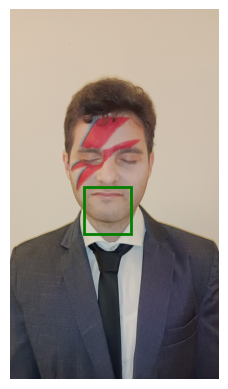

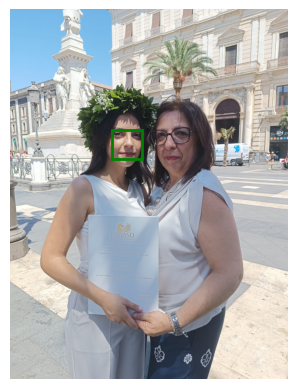

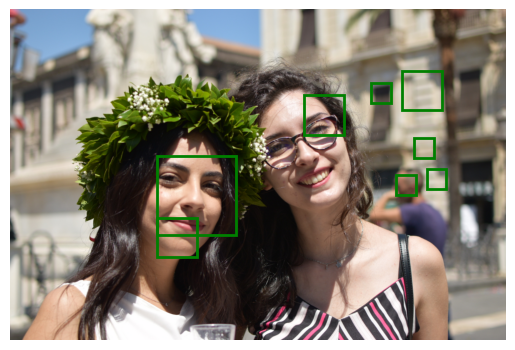

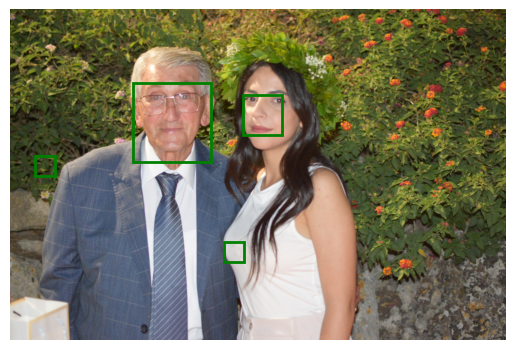

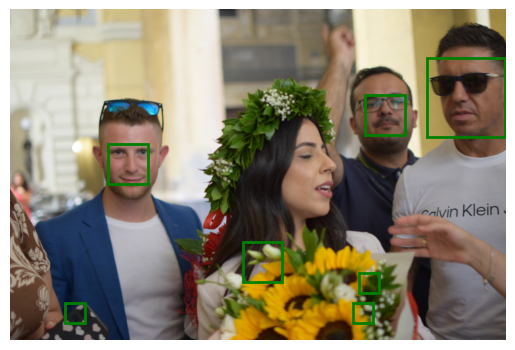

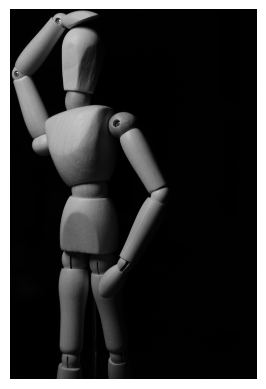

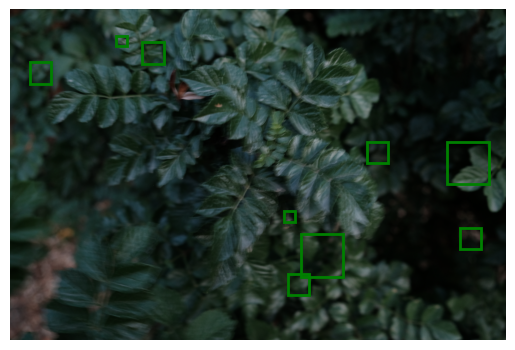

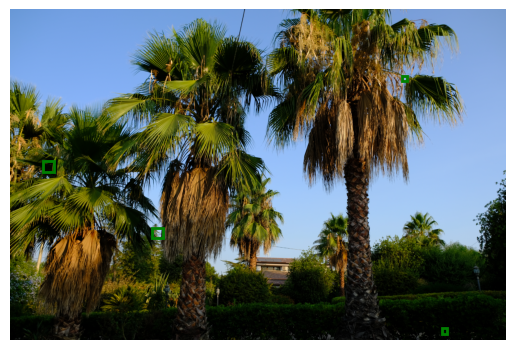

In [24]:
for i in range(1,9):
    face_detection(f"img{i}.jpg")

### Conclusion

Model performs quite good in detecting faces, but is has some limitations: as anticipated in Notebook 1, there could be some false negative when faces have high contrast, or when there are some shadows on them; moreover, the model is trained to detect faces only in frontal position, so other position won't be detected (e.g. profile photos).

As for the false positives, it seems that model gets confused when there are complex patterns, like in plants photos above, while it permforms better if the texture is more regular (see mannequin photo). 

Over all, one can consider this model quite valid, keeping in mind that it relies on few computational resources; more accurate model are possible, but they're in deep learning field that requires much more resources for training, and a larger dataset (thousands of samples, while here there are only 800 samples in total). 